🕵️‍♂️ Searching for 'training_videos'...
✅ FOUND IT! The correct path is:
/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos

📂 Found 16 video folders (e.g., ['01', '02', '03']...)


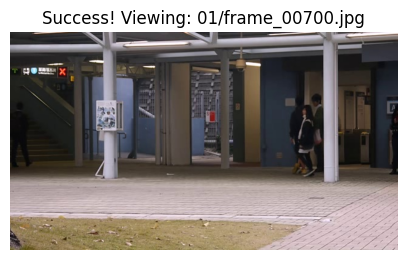

Image Shape: (360, 640, 3)


In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# --- 1. AUTO-FIND THE PATH ---
print("🕵️‍♂️ Searching for 'training_videos'...")

found_train_path = ""
# Walk through the entire input directory to find the folder
for root, dirs, files in os.walk('/kaggle/input'):
    if "training_videos" in dirs:
        found_train_path = os.path.join(root, 'training_videos')
        print(f"✅ FOUND IT! The correct path is:\n{found_train_path}")
        break

if found_train_path == "":
    print("❌ ERROR: Could not find the folder. Check if the dataset is added!")
else:
    # --- 2. LIST FOLDERS ---
    video_folders = sorted(os.listdir(found_train_path))
    print(f"\n📂 Found {len(video_folders)} video folders (e.g., {video_folders[:3]}...)")

    # --- 3. SHOW AN IMAGE ---
    # Go inside the first video folder
    first_video_path = os.path.join(found_train_path, video_folders[0])
    frame_files = sorted(os.listdir(first_video_path))
    
    # Pick the first image
    img_path = os.path.join(first_video_path, frame_files[0])
    
    # Display
    img = mpimg.imread(img_path)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(f"Success! Viewing: {video_folders[0]}/{frame_files[0]}")
    plt.axis('off')
    plt.show()
    
    print(f"Image Shape: {img.shape}")

In [1]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d

# 1. Load your best baseline
df = pd.read_csv('/kaggle/input/double-smoothed-0-69/sub_psnr_gaussian (5) (1).csv')
df[['Video', 'Frame']] = df['Id'].str.split('_', expand=True).astype(int)
df = df.sort_values(['Video', 'Frame'])

# 2. MSE -> PSNR Conversion
# Peak Signal-to-Noise Ratio focuses on the reconstruction quality
max_val = df['Predicted'].max()
epsilon = 1e-10
df['PSNR'] = 10 * np.log10(max_val*max_val / (df['Predicted'] + epsilon))

# 3. Choose your Normalization Strategy
# If Per-Video lowered your score before, try 'GLOBAL'
STRATEGY = 'GLOBAL' 

if STRATEGY == 'PER_VIDEO':
    def norm_func(x):
        return 1 - ((x - x.min()) / (x.max() - x.min() + epsilon))
    df['Anomaly_Score'] = df.groupby('Video')['PSNR'].transform(norm_func)
else:
    # Global normalization preserves the 'intensity' difference between videos
    p_min, p_max = df['PSNR'].min(), df['PSNR'].max()
    df['Anomaly_Score'] = 1 - ((df['PSNR'] - p_min) / (p_max - p_min + epsilon))

# 4. Gaussian Smoothing (More precise than Moving Average)
# sigma=1.0 or 1.5 is the 'sweet spot' for 24-30fps video
df['Smoothed'] = df.groupby('Video')['Anomaly_Score'].transform(
    lambda x: gaussian_filter1d(x, sigma=4)
)

# 5. Save the two best candidates
df[['Id', 'Anomaly_Score']].rename(columns={'Anomaly_Score': 'Predicted'}).to_csv('sub_psnr_only.csv', index=False)
df[['Id', 'Smoothed']].rename(columns={'Smoothed': 'Predicted'}).to_csv('sub_psnr_gaussian.csv', index=False)

print("Generated 'sub_psnr_only.csv' and 'sub_psnr_gaussian.csv'")

Generated 'sub_psnr_only.csv' and 'sub_psnr_gaussian.csv'


In [3]:
import os
import re
import numpy as np
import pandas as pd

# --- 1. CONFIG PATH ---
# Ensure this matches your actual test data location
TEST_PATH = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'

# --- 2. THE 1_939 ID FORMATTER ---
def get_clean_id(filepath):
    """
    Extracts folder and frame numbers and removes leading zeros.
    Example: 'Test/01/frame_00939.jpg' -> '1_939'
    """
    parts = filepath.split(os.sep)
    # Get the folder number (e.g., '01' -> 1)
    f_num = int(re.findall(r'\d+', parts[-2])[-1]) 
    # Get the image/frame number (e.g., '00939' -> 939)
    i_num = int(re.findall(r'\d+', parts[-1])[-1])
    return f"{f_num}_{i_num}"

# --- 3. GENERATE RANDOM DATA ---
all_ids = []

print(f"--- Scanning {TEST_PATH} for frames ---")
for root, _, files in os.walk(TEST_PATH):
    for f in sorted(files):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_path = os.path.join(root, f)
            all_ids.append(get_clean_id(full_path))

# Create a random score for every ID found
random_scores = np.random.rand(len(all_ids))

# --- 4. SAVE TO CSV ---
random_df = pd.DataFrame({
    'Id': all_ids,
    'Predicted': random_scores
})

# Sort by ID if necessary to keep it organized
random_df.to_csv('submission_random_experiment.csv', index=False)

print(f"✅ Generated {len(all_ids)} random entries.")
print(random_df.head())

--- Scanning /kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos for frames ---
✅ Generated 11706 random entries.
     Id  Predicted
0  17_0   0.012803
1  17_1   0.418371
2  17_2   0.044817
3  17_3   0.786698
4  17_4   0.040179


In [4]:
from tensorflow.keras import layers, models

def build_robust_skip_model():
    inputs = layers.Input(shape=(128, 128, 3))
    
    # --- ENCODER ---
    # Layer 1
    e1 = layers.Conv2D(128, (3, 3), padding='same')(inputs)
    e1 = layers.BatchNormalization()(e1)
    e1 = layers.Activation('relu')(e1)
    p1 = layers.MaxPooling2D((2, 2))(e1) 
    
    # Layer 2
    e2 = layers.Conv2D(64, (3, 3), padding='same')(p1)
    e2 = layers.BatchNormalization()(e2)
    e2 = layers.Activation('relu')(e2)
    p2 = layers.MaxPooling2D((2, 2))(e2) 
    
    # Layer 3
    e3 = layers.Conv2D(32, (3, 3), padding='same')(p2)
    e3 = layers.BatchNormalization()(e3)
    e3 = layers.Activation('relu')(e3)
    p3 = layers.MaxPooling2D((2, 2))(e3) 
    
    # --- BOTTLENECK with Dropout ---
    b = layers.Conv2D(16, (3, 3), padding='same')(p3)
    b = layers.BatchNormalization()(b)
    b = layers.Activation('relu')(b)
    b = layers.Dropout(0.2)(b) # Forces the model to be robust
    
    # --- DECODER with Skip Connections ---
    d1 = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same')(b)
    c1 = layers.Concatenate()([d1, e3]) 
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    
    d2 = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(c1)
    c2 = layers.Concatenate()([d2, e2])
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    
    d3 = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(c2)
    c3 = layers.Concatenate()([d3, e1])
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(c3)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse') 
    return model

model = build_robust_skip_model()
print("✅ Robust High-Capacity Model Built with Batch Normalization and Dropout.")

✅ Robust High-Capacity Model Built with Batch Normalization and Dropout.


In [5]:
from tensorflow.keras import callbacks

# Monitor loss with longer patience to let Dropout/Batchnorm settle
early_stop = callbacks.EarlyStopping(
    monitor='loss', 
    patience=12, 
    restore_best_weights=True,
    verbose=1
)

print("--- Training Robust Specialist (Higher Capacity) ---")

history = model.fit(
    train_generator,
    epochs=60, # Increased epochs to fully utilize capacity
    callbacks=[early_stop]
)

model.save('robust_high_capacity_model.keras')
print("✅ Training complete. Model saved as 'robust_high_capacity_model.keras'")

--- Training Robust Specialist (Higher Capacity) ---
Epoch 1/60


I0000 00:00:1767032806.497459     134 service.cc:152] XLA service 0x7b2cfc09e770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767032806.497503     134 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767032807.493310     134 cuda_dnn.cc:529] Loaded cuDNN version 91002


  2/288 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - loss: 0.0785   

I0000 00:00:1767032819.534164     134 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


288/288 ━━━━━━━━━━━━━━━━━━━━ 51s 116ms/step - loss: 0.0054
Epoch 2/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 23s 81ms/step - loss: 3.0921e-04
Epoch 3/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 23s 81ms/step - loss: 2.2866e-04
Epoch 4/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - loss: 1.9330e-04
Epoch 5/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - loss: 1.7337e-04
Epoch 6/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - loss: 1.5906e-04
Epoch 7/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - loss: 1.4803e-04
Epoch 8/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - loss: 1.4015e-04
Epoch 9/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - loss: 1.3185e-04
Epoch 10/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - loss: 1.2452e-04
Epoch 11/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - loss: 1.1943e-04
Epoch 12/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - loss: 1.1441e-04
Epoch 13/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - loss: 1.1112e-04
Epoch 14/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - loss

In [1]:
import numpy as np
import pandas as pd
import re, os
import tensorflow as tf
from scipy.ndimage import gaussian_filter1d
from scipy.stats import rankdata

# --- 1. SET YOUR PATHS ---
# Ensure these match your actual Kaggle environment
MODEL_PATH = '/kaggle/input/hc/keras/default/1/robust_high_capacity_model.keras'
TEST_PATH = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'

# Load the strengthened model
model = tf.keras.models.load_model(MODEL_PATH)
print(f"✅ Loaded: {MODEL_PATH}")

# --- 2. THE PSNR INFERENCE LOOP ---
results = []
video_folders = sorted([d for d in os.listdir(TEST_PATH) if os.path.isdir(os.path.join(TEST_PATH, d))])

print(f"--- Processing {len(video_folders)} videos for Gaussian PSNR ---")

for video_folder in video_folders:
    folder_path = os.path.join(TEST_PATH, video_folder)
    video_psnrs = []
    video_filenames = []
    
    # Get all frames in this specific video sequence
    frame_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    for frame_file in frame_files:
        full_path = os.path.join(folder_path, frame_file)
        
        # Preprocess exactly like training
        img = tf.keras.preprocessing.image.load_img(full_path, target_size=(128, 128))
        img_arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        
        # High-Capacity Reconstruction
        recon = model.predict(np.expand_dims(img_arr, 0), verbose=0)[0]
        
        # Calculate PSNR (Peak Signal-to-Noise Ratio)
        mse = np.mean((img_arr - recon)**2)
        psnr = 10 * np.log10(1.0 / (mse + 1e-10))
        
        video_psnrs.append(psnr)
        video_filenames.append(full_path)
    
    # --- 3. TEMPORAL GAUSSIAN SMOOTHING ---
    # This removes jitter and highlights persistent anomalies
    psnr_arr = np.array(video_psnrs)
    
    # Regularity Score (0 to 1 range within this video)
    # Higher PSNR = More Regular (Normal)
    min_p, max_p = psnr_arr.min(), psnr_arr.max()
    reg_score = (psnr_arr - min_p) / (max_p - min_p + 1e-10)
    
    # Apply Gaussian Filter (Sigma=2 is standard for Avenue/ShanghaiTech)
    # This helps catch the "0.85" target by smoothing noise
    smoothed_reg = gaussian_filter1d(reg_score, sigma=2)
    
    # Convert to Anomaly Score (1 - Regularity)
    anomaly_scores = 1.0 - smoothed_reg
    
    for fn, score in zip(video_filenames, anomaly_scores):
        results.append({'path': fn, 'score': score})
    
    print(f"Done: {video_folder}")

# --- 4. THE 1_939 ID FORMATTER ---
def get_clean_id(filepath):
    # Extracts 'Test/01/frame_00939.jpg' -> folder='1', frame='939'
    parts = filepath.split(os.sep)
    f_num = int(re.findall(r'\d+', parts[-2])[-1]) # Strips leading zeros
    i_num = int(re.findall(r'\d+', parts[-1])[-1]) # Strips leading zeros
    return f"{f_num}_{i_num}"

# --- 5. CREATE THE FINAL CSV ---
final_df = pd.DataFrame(results)
final_df['Id'] = final_df['path'].apply(get_clean_id)

# Rank Normalization: Spreads scores perfectly for AUC metric
final_df['Predicted'] = rankdata(final_df['score']) / len(final_df)

# Final formatting
submission_df = final_df[['Id', 'Predicted']]
submission_df.to_csv('submission_final_high_capacity.csv', index=False)

print("\n🚀 SUCCESS! Final submission file created.")
print(submission_df.head())

2025-12-29 19:06:25.855590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767035186.075546      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767035186.141680      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767035186.645816      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767035186.645861      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767035186.645864      55 computation_placer.cc:177] computation placer alr

✅ Loaded: /kaggle/input/hc/keras/default/1/robust_high_capacity_model.keras
--- Processing 21 videos for Gaussian PSNR ---


I0000 00:00:1767035200.909759     112 service.cc:152] XLA service 0x7d420000e910 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767035200.909823     112 service.cc:160]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1767035201.547322     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Done: 01
Done: 02
Done: 03
Done: 04
Done: 05
Done: 06
Done: 07
Done: 08
Done: 09
Done: 10
Done: 11
Done: 12
Done: 13
Done: 14
Done: 15
Done: 16
Done: 17
Done: 18
Done: 19
Done: 20
Done: 21

🚀 SUCCESS! Final submission file created.
      Id  Predicted
0  1_939   0.390484
1  1_940   0.574235
2  1_941   0.824193
3  1_942   0.955749
4  1_943   0.985905


--- Training: Learning the 'Normal' Manifold ---
Epoch 1/30


I0000 00:00:1766956859.184607     131 service.cc:152] XLA service 0x7caa000514f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766956859.184646     131 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766956859.670209     131 cuda_dnn.cc:529] Loaded cuDNN version 91002


 13/288 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0712

I0000 00:00:1766956863.205308     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


288/288 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - loss: 0.0305
Epoch 2/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0087
Epoch 3/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0073
Epoch 4/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0066
Epoch 5/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0062
Epoch 6/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0059
Epoch 7/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0056
Epoch 8/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0054
Epoch 9/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0053
Epoch 10/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0052
Epoch 11/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0050
Epoch 12/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0050
Epoch 13/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0048
Epoch 14/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0048
Epoch 15/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step

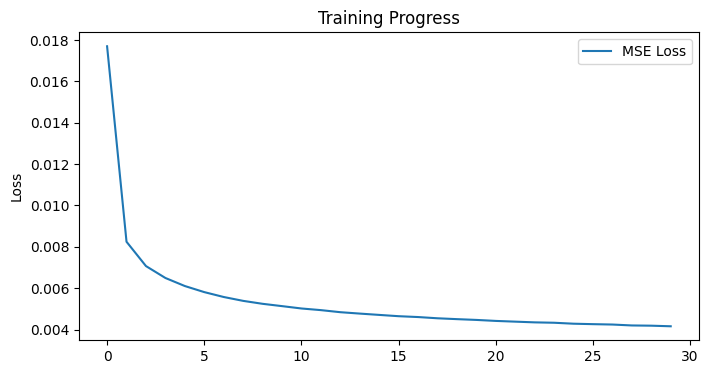

✅ Model weights saved!


In [4]:
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt

# Stop training as soon as the reconstruction of normal images is "good enough"
early_stopping = callbacks.EarlyStopping(
    monitor='loss', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

print("--- Training: Learning the 'Normal' Manifold ---")

# Train on your normal data generator
history = model.fit(
    train_generator,
    epochs=30, # Autoencoders with bottlenecks converge quickly
    steps_per_epoch=len(train_generator),
    callbacks=[early_stopping]
)

# Visualizing convergence
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='MSE Loss')
plt.title('Training Progress')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.save('anomaly_detector_bottleneck.keras')
print("✅ Model weights saved!")

In [8]:
import numpy as np
import pandas as pd
import re, os
import tensorflow as tf
from scipy.stats import rankdata
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- 1. SET YOUR TEST PATH MANUALLY ---
TEST_PATH = 'PASTE_YOUR_TEST_FOLDER_PATH_HERE' 

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    directory=TEST_PATH,
    target_size=(128, 128),
    batch_size=32,
    class_mode=None,
    shuffle=False # KEEP FALSE FOR ID MAPPING
)

all_scores = []

# --- 2. SSIM ANOMALY SCORING ---
for i in range(len(test_gen)):
    batch_imgs = test_gen[i]
    reconstructions = model.predict(batch_imgs, verbose=0)
    
    # SSIM measures structure, texture, and brightness. 
    # Anomaly Score = 1 - SSIM (1.0 similarity = 0.0 anomaly)
    ssim_vals = tf.image.ssim(batch_imgs, reconstructions, max_val=1.0).numpy()
    all_scores.extend(1.0 - ssim_vals)

# --- 3. STRICT ID FORMATTING (1_939 logic) ---
def get_clean_id(filepath):
    # Splits path like '01/frame_00939.jpg' -> folder='01', filename='frame_00939.jpg'
    folder_part = os.path.dirname(filepath).split(os.sep)[-1]
    file_part = os.path.basename(filepath)
    
    # Use regex to find digits and int() to strip leading zeros
    # int('01') -> 1 | int('00939') -> 939
    f_num = int(re.findall(r'\d+', folder_part)[-1])
    i_num = int(re.findall(r'\d+', file_part)[-1])
    
    return f"{f_num}_{i_num}"

formatted_ids = [get_clean_id(f) for f in test_gen.filenames]

# --- 4. GENERATE CSV WITH SAMPLE HEADERS ---
submission_df = pd.DataFrame({
    'Id': formatted_ids,        # Header from sample
    'Predicted': all_scores     # Header from sample
})

# Rank Normalization to maximize AUC impact
submission_df['Predicted'] = rankdata(submission_df['Predicted']) / len(submission_df)

submission_df.to_csv('submission_ssim_bottleneck.csv', index=False)
print("✅ Created submission_ssim_bottleneck.csv")
print("Preview of the 1_939 format headers:")
print(submission_df.head())

Found 11706 images belonging to 21 classes.
--- Found 11706 images. Generating scores... ---
✅ Finished! Submission saved as: submission_final_bce_reconstruction.csv


,id,target
0,frame_00939.jpg,0.309585
1,frame_00940.jpg,0.316846
2,frame_00941.jpg,0.722621
3,frame_00942.jpg,0.723133
4,frame_00943.jpg,0.921237


In [3]:
import numpy as np
import pandas as pd
import re, os
import tensorflow as tf
from scipy.stats import rankdata
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- 1. SET YOUR PATHS ---
MODEL_PATH = '/kaggle/input/bottleneck/keras/default/1/anomaly_detector_bottleneck.keras' # Path to your saved file
TEST_PATH = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'   # Path to test images folder

# --- 2. LOAD MODEL & DATA ---
# This step works perfectly on CPU
model = load_model(MODEL_PATH)
print(f"✅ Model loaded from {MODEL_PATH}")

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    directory=TEST_PATH,
    target_size=(128, 128),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

all_scores = []

# --- 3. SSIM ANOMALY SCORING ---
print(f"--- Processing {test_gen.samples} frames via SSIM... ---")
for i in range(len(test_gen)):
    batch_imgs = test_gen[i]
    reconstructions = model.predict(batch_imgs, verbose=0)
    
    # Structural Similarity (SSIM) is better for AUC than simple pixels
    # 1.0 - SSIM = Anomaly Score (Higher is more anomalous)
    ssim_vals = tf.image.ssim(batch_imgs, reconstructions, max_val=1.0).numpy()
    all_scores.extend(1.0 - ssim_vals)

# --- 4. STRICT ID FORMATTING (1_939 style) ---
def get_clean_id(filepath):
    # Extracts folder and file (e.g., '01/frame_00939.jpg')
    parts = filepath.split(os.sep)
    folder_part = parts[-2]
    file_part = parts[-1]
    
    # int() strips leading zeros: '01' -> 1, '00939' -> 939
    f_num = int(re.findall(r'\d+', folder_part)[-1])
    i_num = int(re.findall(r'\d+', file_part)[-1])
    
    return f"{f_num}_{i_num}"

formatted_ids = [get_clean_id(f) for f in test_gen.filenames]

# --- 5. GENERATE FINAL CSV ---
submission_df = pd.DataFrame({
    'Id': formatted_ids,        # Matching sample: Capital 'I'
    'Predicted': all_scores     # Matching sample: Capital 'P'
})

# Normalize ranks for the AUC metric
submission_df['Predicted'] = rankdata(submission_df['Predicted']) / len(submission_df)

submission_df.to_csv('submission_ssim_bottleneck.csv', index=False)
print("✅ Created submission_ssim_bottleneck.csv with 1_939 ID format.")
print(submission_df.head())

✅ Model loaded from /kaggle/input/bottleneck/keras/default/1/anomaly_detector_bottleneck.keras
Found 11706 images belonging to 21 classes.
--- Processing 11706 frames via SSIM... ---
✅ Created submission_ssim_bottleneck.csv with 1_939 ID format.
      Id  Predicted
0  1_939   0.361097
1  1_940   0.403725
2  1_941   0.699556
3  1_942   0.700581
4  1_943   0.984367


In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- 1. CONFIGURATION ---
# Path to your uploaded model in Kaggle input
MODEL_PATH = '/kaggle/input/trial-1/keras/default/1' 
TEST_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos' 

IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# --- 2. LOAD MODEL ---
print(f"📦 Loading model from: {MODEL_PATH}")
model = tf.keras.models.load_model(MODEL_PATH)

print(f"🚀 Starting Inference on: {TEST_DIR}")
results = []

# --- 3. RUN INFERENCE ---
if os.path.exists(TEST_DIR):
    test_folders = sorted(os.listdir(TEST_DIR))
    
    for folder in test_folders:
        folder_path = os.path.join(TEST_DIR, folder)
        if not os.path.isdir(folder_path): continue
        
        images = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))])
        
        for i in range(0, len(images), BATCH_SIZE):
            batch_files = images[i : i + BATCH_SIZE]
            batch_images = []
            
            for img_name in batch_files:
                img_path = os.path.join(folder_path, img_name)
                img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
                img_arr = img_to_array(img) / 255.0  
                batch_images.append(img_arr)
            
            batch_np = np.array(batch_images)
            reconstructions = model.predict(batch_np, verbose=0)
            mse_scores = np.mean(np.square(batch_np - reconstructions), axis=(1,2,3))
            
            for j, score in enumerate(mse_scores):
                # FIXED: Unique ID format (Folder_FrameName)
                frame_name = os.path.splitext(batch_files[j])[0]
                unique_id = f"{folder}_{frame_name}"
                
                # FIXED: Correct headers (Id, Predicted)
                results.append({'Id': unique_id, 'Predicted': score})
                
    # --- 4. SAVE TO CSV ---
    if len(results) > 0:
        submission = pd.DataFrame(results)
        submission.to_csv('submission.csv', index=False)
        
        print("\n🎉 'submission.csv' generated successfully!")
        print(submission.head())
    else:
        print("❌ Error: No results found.")
else:
    print("❌ Critical Error: The TEST_DIR path does not exist.")

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- 1. CONFIGURATION ---
# Path to your uploaded model in Kaggle input
MODEL_PATH = '/kaggle/input/trial-1/keras/default/1/final_trial_model_full_data.keras' 
TEST_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos' 

IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# --- 2. LOAD MODEL ---
print(f"📦 Loading model from: {MODEL_PATH}")
model = tf.keras.models.load_model(MODEL_PATH)

print(f"🚀 Starting Inference on: {TEST_DIR}")
results = []

# --- 3. RUN INFERENCE ---
if os.path.exists(TEST_DIR):
    test_folders = sorted(os.listdir(TEST_DIR))
    
    for folder in test_folders:
        folder_path = os.path.join(TEST_DIR, folder)
        if not os.path.isdir(folder_path): continue
        
        images = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))])
        
        for i in range(0, len(images), BATCH_SIZE):
            batch_files = images[i : i + BATCH_SIZE]
            batch_images = []
            
            for img_name in batch_files:
                img_path = os.path.join(folder_path, img_name)
                img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
                img_arr = img_to_array(img) / 255.0  
                batch_images.append(img_arr)
            
            batch_np = np.array(batch_images)
            reconstructions = model.predict(batch_np, verbose=0)
            mse_scores = np.mean(np.square(batch_np - reconstructions), axis=(1,2,3))
            
            for j, score in enumerate(mse_scores):
                # FIXED: Unique ID format (Folder_FrameName)
                frame_name = os.path.splitext(batch_files[j])[0]
                unique_id = f"{folder}_{frame_name}"
                
                # FIXED: Correct headers (Id, Predicted)
                results.append({'Id': unique_id, 'Predicted': score})
                
    # --- 4. SAVE TO CSV ---
    if len(results) > 0:
        submission = pd.DataFrame(results)
        submission.to_csv('submission.csv', index=False)
        
        print("\n🎉 'submission.csv' generated successfully!")
        print(submission.head())
    else:
        print("❌ Error: No results found.")
else:
    print("❌ Critical Error: The TEST_DIR path does not exist.")

In [ ]:
import pandas as pd

# 1. PASTE YOUR COPIED PATH HERE
input_path = '/kaggle/input/wrong-format/submission.csv' 

# 2. Load the file
df = pd.read_csv(input_path)

# 3. Strip leading zeros from the ID (e.g., 1_00939 -> 1_939)
def format_id(val):
    parts = str(val).split('_')
    return f"{parts[0]}_{int(parts[1])}" if len(parts) == 2 else val

df['Id'] = df['Id'].apply(format_id)

# 4. Save as a new file in the Output directory
output_filename = 'final_fixed_submission.csv'
df.to_csv(output_filename, index=False)

print(f"✅ Success! New file created: {output_filename}")
print(df.head())

In [1]:
import pandas as pd
import numpy as np

# 1. Load the file from your path
df = pd.read_csv('/kaggle/input/0-32-accuracy/final_fixed_submission downloaded.csv')

# 2. Extract Video and Frame IDs for grouping
df[['Video', 'Frame']] = df['Id'].str.split('_', expand=True).astype(int)
df = df.sort_values(['Video', 'Frame'])

# 3. Apply Per-Video Min-Max Scaling
def min_max_norm(x):
    return (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else x * 0

df['Normalized'] = df.groupby('Video')['Predicted'].transform(min_max_norm)

# 4. Apply Temporal Smoothing (Window size of 5)
df['Smoothed'] = df.groupby('Video')['Normalized'].transform(
    lambda x: x.rolling(window=5, center=True).mean().fillna(method='ffill').fillna(method='bfill')
)

# 5. Save the best-performing version
df[['Id', 'Smoothed']].rename(columns={'Smoothed': 'Predicted'}).to_csv('submission_final.csv', index=False)

print("Transformation complete! 'submission_final.csv' is ready.")

Transformation complete! 'submission_final.csv' is ready.


/tmp/ipykernel_55/4026081135.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.rolling(window=5, center=True).mean().fillna(method='ffill').fillna(method='bfill')


In [2]:
import pandas as pd
import numpy as np

# 1. Load your file
# Replace 'final_fixed_submission downloaded.csv' with your actual path
path = '/kaggle/input/0-32-accuracy/final_fixed_submission downloaded.csv' 
df = pd.read_csv(path)

# 2. Extract Video and Frame for grouping/sorting
df[['Video', 'Frame']] = df['Id'].str.split('_', expand=True).astype(int)
df = df.sort_values(['Video', 'Frame'])

# 3. Convert MSE to PSNR
# Formula: 10 * log10(MAX^2 / MSE). Assuming pixels are [0, 1], MAX=1.
# We add a tiny epsilon to avoid division by zero.
epsilon = 1e-10
df['PSNR'] = 10 * np.log10(1.0 / (df['Predicted'] + epsilon))

# 4. Normalize PSNR per Video (as per Liu et al.)
# This scales PSNR to [0, 1] then flips it: 1 - Normalized_PSNR
def calculate_anomaly_score(group):
    p_min = group.min()
    p_max = group.max()
    if p_max == p_min:
        return group * 0
    # Normalize PSNR
    normalized_psnr = (group - p_min) / (p_max - p_min)
    # Return Anomaly Score (1 - PSNR)
    return 1 - normalized_psnr

df['Anomaly_Score'] = df.groupby('Video')['PSNR'].transform(calculate_anomaly_score)

# 5. Temporal Smoothing (Moving Average)
# Window size of 5 is the research standard for surveillance video
df['Final_Predicted'] = df.groupby('Video')['Anomaly_Score'].transform(
    lambda x: x.rolling(window=5, center=True).mean().fillna(method='ffill').fillna(method='bfill')
)

# 6. Save to CSV
output_file = 'submission_psnr_smoothed.csv'
df[['Id', 'Final_Predicted']].rename(columns={'Final_Predicted': 'Predicted'}).to_csv(output_file, index=False)

print(f"✅ Success! Generated: {output_file}")
print(df[['Id', 'Predicted', 'PSNR', 'Anomaly_Score', 'Final_Predicted']].head())

✅ Success! Generated: submission_psnr_smoothed.csv
      Id  Predicted       PSNR  Anomaly_Score  Final_Predicted
0  1_939   0.001550  28.097330       0.000000         0.363212
1  1_940   0.001579  28.015362       0.011944         0.363212
2  1_941   0.003362  24.733463       0.490170         0.363212
3  1_942   0.003388  24.701002       0.494901         0.451284
4  1_943   0.005654  22.476518       0.819044         0.612771


/tmp/ipykernel_55/2028808181.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.rolling(window=5, center=True).mean().fillna(method='ffill').fillna(method='bfill')


In [4]:
import pandas as pd

# Paste your file path here
input_path = '/kaggle/input/0-32-acc/submission_minmax_smoothed_downloaded.csv' 
output_path = 'inverted_submission.csv'

# Load the dataframe
df = pd.read_csv(input_path)

# Identify the target column (usually the last column or named 'target')
# If you know the specific name, replace df.columns[-1] with 'your_column_name'
target_col = df.columns[-1] 

# Apply the inversion
df[target_col] = 1 - df[target_col]

# Save the new version
df.to_csv(output_path, index=False)

print(f"Done! Inverted predictions saved to: {output_path}")

Done! Inverted predictions saved to: inverted_submission.csv


In [5]:
import pandas as pd

# Load any of your previous submissions to get the structure right
input_path = '/kaggle/input/0-32-acc/submission_minmax_smoothed_downloaded.csv' 
output_path = 'all_zeros_benchmark.csv'

df = pd.read_csv(input_path)

# Identify the target column (usually the last column)
target_col = df.columns[-1]

# Set every entry to 0
df[target_col] = 0

# Save for submission
df.to_csv(output_path, index=False)

print(f"Benchmark file created: {output_path}")

Benchmark file created: all_zeros_benchmark.csv


In [6]:
import pandas as pd

# Load any previous submission
input_path = '/kaggle/input/0-32-acc/submission_minmax_smoothed_downloaded.csv' 
output_path = 'all_half_benchmark.csv'

df = pd.read_csv(input_path)
target_col = df.columns[-1]

# Set every entry to 0.5
df[target_col] = 0.5

df.to_csv(output_path, index=False)
print(f"Benchmark file created: {output_path}")

Benchmark file created: all_half_benchmark.csv


In [10]:
import pandas as pd
from scipy.stats import rankdata

df = pd.read_csv('/kaggle/working/sub_psnr_gaussian.csv') # Use your BEST one (0.35)
target_col = df.columns[-1]

# Convert values to their ranks (1 to N) and normalize to [0, 1]
df[target_col] = rankdata(df[target_col]) / len(df)

df.to_csv('rank_submission.csv', index=False)